In [2]:
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [3]:
# data directory
DATA_DIR = '../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/220303-doronet_ic.csv'
IC_NET_SUB_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub.csv'
ROAD_CSV = f'{DATA_DIR}/road_master/220303-douro.csv'

# 検索ログ csv
SEARCH_LOG_DIR = lambda month: f'{DATA_DIR}/search_records/csv{month}'
SEARCH_LOG_CSV = lambda date: f'{SEARCH_LOG_DIR(date[:6])}/record_{date}.csv'

# 交通量 csv
TRAFFIC_DIR = f'{DATA_DIR}/traffic'
TRAFFIC_KANNETSU_CSV = f'{TRAFFIC_DIR}/traffic_kannetsu.csv'
TRAFFIC_TATEYAMA_CSV = f'{TRAFFIC_DIR}/traffic_tateyama.csv'

# 検索量 csv
SEARCH_COUNT_DIR = f'{DATA_DIR}/search_count'
SEARCH_COUNT_TATEYAMA_CSV = f'{SEARCH_COUNT_DIR}/search-count_tateyama.csv'
SEARCH_COUNT_KANNETSU_CSV = f'{SEARCH_COUNT_DIR}/search-count_kannetsu.csv'

In [4]:
df_ic = pd.read_csv(IC_CSV)
df_icnet = pd.read_csv(IC_NET_SUB_CSV, dtype={'start_code': str, 'end_code': str})

code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

In [5]:
ic_subgraph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                      edge_attr=['distance', 'road_code', 'direction'],
                                      create_using=nx.DiGraph())

### 「台数」の空間的な相関

In [8]:
tateyama = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True, dtype={'start_code': str, 'end_code': str}).reset_index()
kannetsu = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True, dtype={'start_code': str, 'end_code': str}).reset_index()

In [40]:
def resample(df, sr):
  agg_map = {
      'KP': 'mean',
      'total': 'sum',
      'speed': 'mean',
  }

  return df.set_index('datetime').groupby(['start_code', 'end_code']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()


def calc_corr(df, col1, col2):
  return df[[col1, col2]].corr().values[0, 1]

In [38]:
tat = tateyama[(tateyama['datetime'] >= '2022-04-29') & (tateyama['datetime'] < '2022-05-09')]
kan = kannetsu[(kannetsu['datetime'] >= '2022-04-29') & (kannetsu['datetime'] < '2022-05-09')]

tat = resample(tat, '1h')
kan = resample(kan, '1h')

In [44]:
sec_tat = tat[['start_code', 'end_code']].drop_duplicates().values
sec_kan = kan[['start_code', 'end_code']].drop_duplicates().values

In [57]:
res = []
for i, sec1 in enumerate(sec_kan):
  tmp1 = kan[(kan['start_code'] == sec1[0]) & (kan['end_code'] == sec1[1])]['total']
  for j, sec2 in enumerate(sec_kan):
    if j <= i:
      continue
    
    tmp2 = kan[(kan['start_code'] == sec2[0]) & (kan['end_code'] == sec2[1])]['total']
    corr = np.corrcoef(tmp1, tmp2)[0,1]
    res.append((corr, sec1, sec2))

In [58]:
res = sorted(res, key=lambda l: l[0], reverse=True)

In [66]:
for i, r in enumerate(res):
  # if i > 60:
  #   break
  if 0.85 < r[0] < 0.95:
    n11, n12 = (code2name[r[1][0]], code2name[r[1][1]])
    n21, n22 = (code2name[r[2][0]], code2name[r[2][1]])
    if '渋川伊香保' in {n11, n12, n21, n22}:
      print(f'{n11} -> {n12} : {n21} -> {n22}:: {r[0]}')

花園 -> 寄居ＰＡ : 渋川伊香保 -> 赤城:: 0.9493114916685204
上里ＳＡ -> 本庄児玉 : 赤城 -> 渋川伊香保:: 0.9475469295945754
寄居ＰＡ -> 花園 : 渋川伊香保 -> 駒寄ＰＡ:: 0.9466265498341516
本庄児玉 -> 寄居ＰＡ : 赤城 -> 渋川伊香保:: 0.939558731750647
赤城 -> 渋川伊香保 : 六日町 -> 塩沢石打:: 0.9388829894316159
高崎ＪＣＴ -> 高崎玉村スマート : 渋川伊香保 -> 駒寄ＰＡ:: 0.9388006718310422
渋川伊香保 -> 駒寄ＰＡ : 塩沢石打 -> 湯沢(関越道):: 0.9366983538090031
嵐山小川 -> 花園 : 渋川伊香保 -> 赤城:: 0.93604935638122
寄居ＰＡ -> 花園 : 赤城 -> 渋川伊香保:: 0.9342476966402284
東松山 -> 嵐山小川 : 駒寄ＰＡ -> 渋川伊香保:: 0.9331379216038365
駒寄ＰＡ -> 渋川伊香保 : 月夜野 -> 水上:: 0.931335711310989
高崎玉村スマート -> 藤岡ＪＣＴ : 渋川伊香保 -> 駒寄ＰＡ:: 0.9301930602472576
高崎ＪＣＴ -> 高崎玉村スマート : 赤城 -> 渋川伊香保:: 0.9264372685373852
渋川伊香保 -> 駒寄ＰＡ : 六日町 -> 塩沢石打:: 0.9255516988069571
花園 -> 嵐山小川 : 渋川伊香保 -> 駒寄ＰＡ:: 0.9250640046982886
赤城 -> 渋川伊香保 : 小出 -> 大和ＰＡ:: 0.9200905179659619
渋川伊香保 -> 赤城 : 水上 -> 湯沢(関越道):: 0.9195330222756686
高崎玉村スマート -> 藤岡ＪＣＴ : 赤城 -> 渋川伊香保:: 0.918133434930577
東松山 -> 嵐山小川 : 渋川伊香保 -> 赤城:: 0.916694068532564
東松山 -> 坂戸西スマート : 渋川伊香保 -> 駒寄ＰＡ:: 0.9162862184921293
嵐山小川 -> 東松山 : 渋川伊香保 -

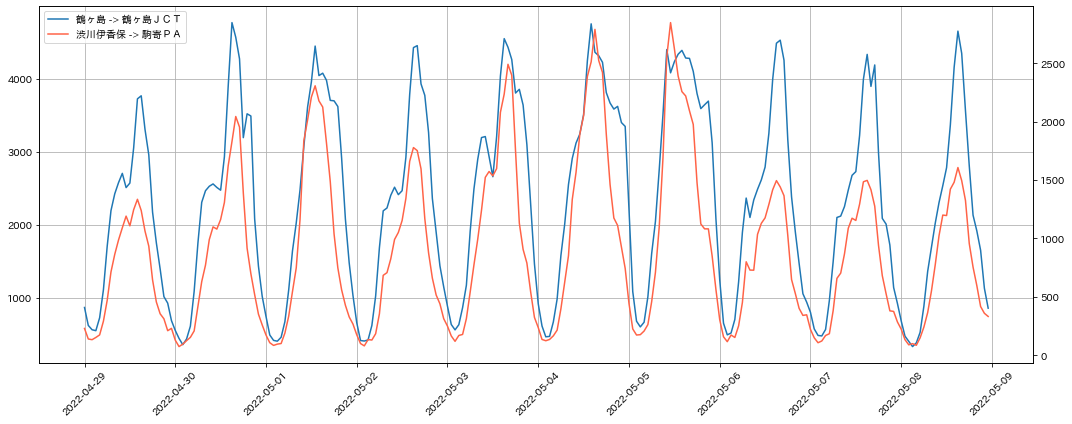

In [89]:
# 鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 渋川伊香保 -> 駒寄ＰＡ:: 0.9142351389692854

tsuru = kan[(kan['start_code'] == name2code['鶴ヶ島']) & (kan['end_code'] == name2code['鶴ヶ島ＪＣＴ'])]
ikaho = kan[(kan['start_code'] == name2code['渋川伊香保']) & (kan['end_code'] == name2code['駒寄ＰＡ'])]

fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)
ax2 = ax.twinx()

ax.plot(tsuru['datetime'], tsuru['total'], label='鶴ヶ島 -> 鶴ヶ島ＪＣＴ')
ax2.plot(ikaho['datetime'], ikaho['total'], color='tomato', label='渋川伊香保 -> 駒寄ＰＡ')

ax.tick_params(axis='x', labelrotation=45)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.grid()

plt.show()

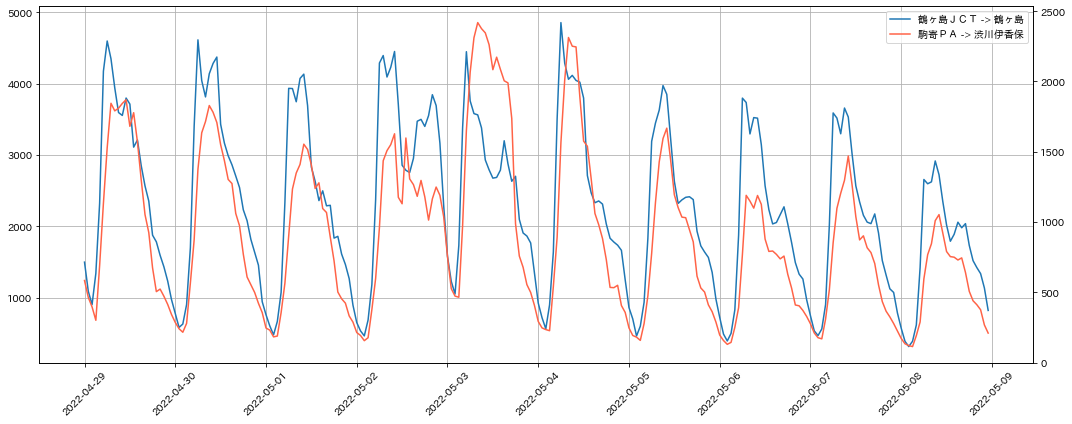

In [90]:
# 鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 駒寄ＰＡ -> 渋川伊香保:: 0.8573708501267392

tsuru = kan[(kan['end_code'] == name2code['鶴ヶ島']) & (kan['start_code'] == name2code['鶴ヶ島ＪＣＴ'])]
ikaho = kan[(kan['end_code'] == name2code['渋川伊香保']) & (kan['start_code'] == name2code['駒寄ＰＡ'])]

fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)
ax2 = ax.twinx()

ax.plot(tsuru['datetime'], tsuru['total'], label='鶴ヶ島ＪＣＴ -> 鶴ヶ島')
ax2.plot(ikaho['datetime'], ikaho['total'], color='tomato', label='駒寄ＰＡ -> 渋川伊香保')

ax.tick_params(axis='x', labelrotation=45)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.grid()

plt.show()

### 「検索数」の空間的な相関

In [92]:
tateyama = pd.read_csv(SEARCH_COUNT_TATEYAMA_CSV, index_col='passing_time', parse_dates=True, dtype={'start_code': str, 'end_code': str}).reset_index()
kannetsu = pd.read_csv(SEARCH_COUNT_KANNETSU_CSV, index_col='passing_time', parse_dates=True, dtype={'start_code': str, 'end_code': str}).reset_index()

In [96]:
def resample(df, sr):
  agg_map = {
    'search': 'sum'
  }

  return df.set_index('passing_time').groupby(['start_code', 'end_code']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()

In [97]:
tat = tateyama[(tateyama['passing_time'] >= '2022-04-29') & (tateyama['passing_time'] < '2022-05-09')]
kan = kannetsu[(kannetsu['passing_time'] >= '2022-04-29') & (kannetsu['passing_time'] < '2022-05-09')]

tat = resample(tat, '1h')
kan = resample(kan, '1h')

In [101]:
sec_tat = tat[['start_code', 'end_code']].drop_duplicates().values
sec_kan = kan[['start_code', 'end_code']].drop_duplicates().values

In [102]:
res = []
for i, sec1 in enumerate(sec_kan):
  tmp1 = kan[(kan['start_code'] == sec1[0]) & (kan['end_code'] == sec1[1])]['search']
  for j, sec2 in enumerate(sec_kan):
    if j <= i:
      continue
    
    tmp2 = kan[(kan['start_code'] == sec2[0]) & (kan['end_code'] == sec2[1])]['search']
    corr = np.corrcoef(tmp1, tmp2)[0,1]
    res.append((corr, sec1, sec2))

In [104]:
res = sorted(res, key=lambda l: l[0], reverse=True)

In [108]:
for i, r in enumerate(res):
  # if i > 60:
  #   break
  # if 0.85 < r[0] < 0.95:
  n11, n12 = (code2name[r[1][0]], code2name[r[1][1]])
  n21, n22 = (code2name[r[2][0]], code2name[r[2][1]])
  if '渋川伊香保' in {n11, n12, n21, n22} and '鶴ヶ島' in {n11, n12, n21, n22}:
    print(f'{n11} -> {n12} : {n21} -> {n22}:: {r[0]}')

鶴ヶ島 -> 坂戸西スマート : 駒寄ＰＡ -> 渋川伊香保:: 0.8812013878518138
鶴ヶ島 -> 坂戸西スマート : 渋川伊香保 -> 赤城ＰＡ:: 0.8810771576581843
鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 渋川伊香保 -> 赤城ＰＡ:: 0.8801884308872127
鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 駒寄ＰＡ -> 渋川伊香保:: 0.8796420302102976
鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 渋川伊香保 -> 駒寄ＰＡ:: 0.7015617548802608
坂戸西スマート -> 鶴ヶ島 : 渋川伊香保 -> 駒寄ＰＡ:: 0.6945688532493036
鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 赤城ＰＡ -> 渋川伊香保:: 0.6874760565366932
坂戸西スマート -> 鶴ヶ島 : 赤城ＰＡ -> 渋川伊香保:: 0.6827981430740144
鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 駒寄ＰＡ -> 渋川伊香保:: 0.6446406299738588
坂戸西スマート -> 鶴ヶ島 : 駒寄ＰＡ -> 渋川伊香保:: 0.6274177790319198
鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 渋川伊香保 -> 赤城ＰＡ:: 0.6143157295266019
鶴ヶ島 -> 坂戸西スマート : 赤城ＰＡ -> 渋川伊香保:: 0.5986163642784728
鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 赤城ＰＡ -> 渋川伊香保:: 0.5971593643336794
坂戸西スマート -> 鶴ヶ島 : 渋川伊香保 -> 赤城ＰＡ:: 0.5955358097753246
鶴ヶ島 -> 坂戸西スマート : 渋川伊香保 -> 駒寄ＰＡ:: 0.5675151602666515
鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 渋川伊香保 -> 駒寄ＰＡ:: 0.5674499182982575


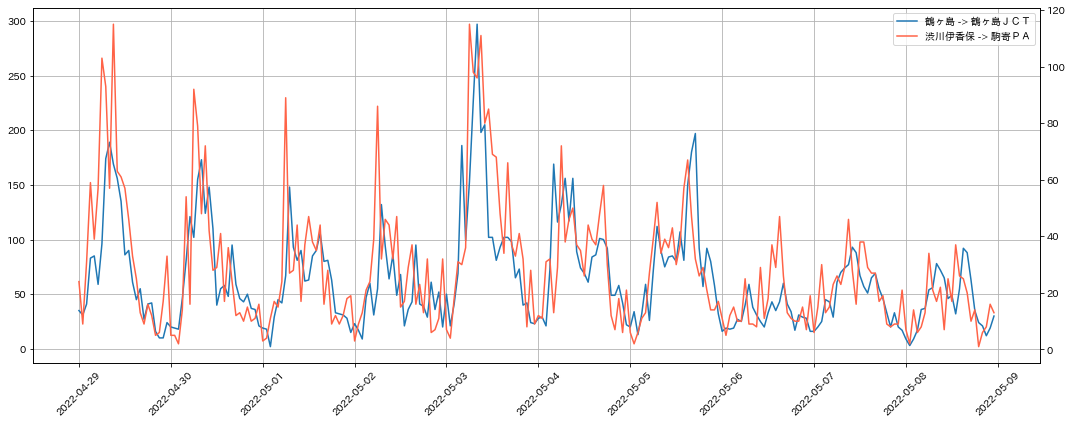

In [110]:
# 鶴ヶ島 -> 鶴ヶ島ＪＣＴ : 渋川伊香保 -> 駒寄ＰＡ:: 0.7015617548802608

tsuru = kan[(kan['start_code'] == name2code['鶴ヶ島']) & (kan['end_code'] == name2code['鶴ヶ島ＪＣＴ'])]
ikaho = kan[(kan['start_code'] == name2code['渋川伊香保']) & (kan['end_code'] == name2code['駒寄ＰＡ'])]

fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)
ax2 = ax.twinx()

ax.plot(tsuru['passing_time'], tsuru['search'], label='鶴ヶ島 -> 鶴ヶ島ＪＣＴ')
ax2.plot(ikaho['passing_time'], ikaho['search'], color='tomato', label='渋川伊香保 -> 駒寄ＰＡ')

ax.tick_params(axis='x', labelrotation=45)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.grid()

plt.show()

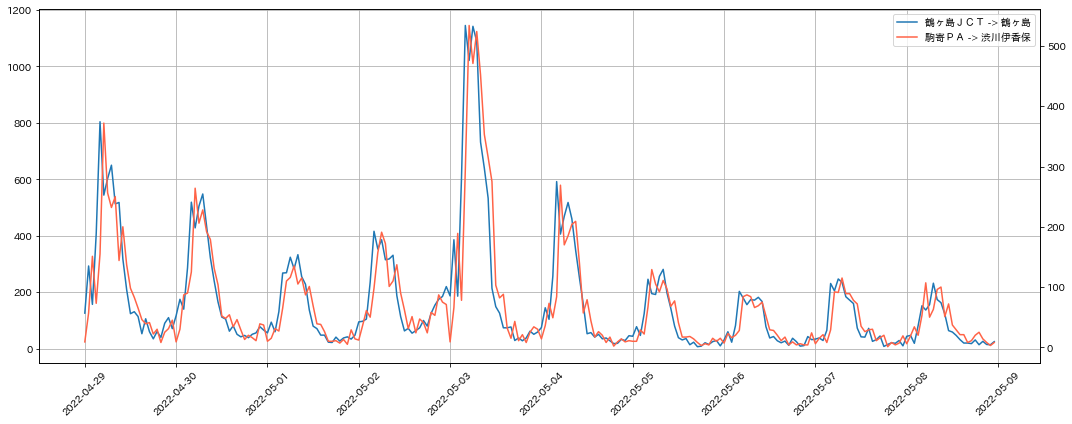

In [111]:
# 鶴ヶ島ＪＣＴ -> 鶴ヶ島 : 駒寄ＰＡ -> 渋川伊香保:: 0.8796420302102976

tsuru = kan[(kan['end_code'] == name2code['鶴ヶ島']) & (kan['start_code'] == name2code['鶴ヶ島ＪＣＴ'])]
ikaho = kan[(kan['end_code'] == name2code['渋川伊香保']) & (kan['start_code'] == name2code['駒寄ＰＡ'])]

fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)
ax2 = ax.twinx()

ax.plot(tsuru['passing_time'], tsuru['search'], label='鶴ヶ島ＪＣＴ -> 鶴ヶ島')
ax2.plot(ikaho['passing_time'], ikaho['search'], color='tomato', label='駒寄ＰＡ -> 渋川伊香保')

ax.tick_params(axis='x', labelrotation=45)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.grid()

plt.show()